In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as mcolors
from datetime import datetime
from datetime import timedelta as dt
from obspy.core.utcdatetime import UTCDateTime  
import h5py
from scipy.signal import butter, filtfilt

# Filepaths + Basic Investigation of CSV Files

In [133]:
#define the filepaths for the P and S wave picks
p_wave_file = '/home/arose17/FM_Segmentation_DAS/src/data/pick_masking/p_mul_picks.csv'
s_wave_file = '/home/arose17/FM_Segmentation_DAS/src/data/pick_masking/s_mul_picks.csv'

In [168]:
#open the p and s wave pick files as numpy arrays
# Read the P and S wave pick files
p_wave_np = pd.read_csv(p_wave_file, header=None).values
s_wave_np = pd.read_csv(s_wave_file, header=None).values



TypeError: Cannot interpret '4500' as a data type

In [135]:
p_0_2250 = p_wave_np[:, :2250]
p_2250_4500 = p_wave_np[:, 2250:]
print(p_0_2250.shape)
print(p_2250_4500.shape)

s_0_2250 = s_wave_np[:, :2250]
s_2250_4500 = s_wave_np[:, 2250:]


(95, 2250)
(95, 2250)


# Starting to interpolate and smooth picks for STD values- Picks 0 - 2250.

In [136]:
#create a numpy array to be the distance vector for the plot which is from 0 to 4499
distance_vector1 = np.arange(0, 2250, 1)


In [ ]:
#create first half of the picks
p_interp1 = np.zeros((1, 2250))
s_interp1 = np.zeros((1, 2250))

In [ ]:
# undergo interpolation of the pand s wave pick dataframes for the first row to ensure reproducibility and then will scale up to the full dataframe
# Fit individual polynomials for p_dataset and s_dataset
p_coeffs_individual = np.polyfit(distance_vector1, p_0_2250[i], deg=1)
s_coeffs_individual = np.polyfit(distance_vector1, s_0_2250[i], deg=1)

# # Calculate the trends
p_trend_individual = np.polyval(p_coeffs_individual, distance_vector1)
s_trend_individual = np.polyval(s_coeffs_individual, distance_vector1)

# # Detrend by subtracting the individual trends
p_interp1 =  p_0_2250[i] - p_trend_individual
s_interp1 =  s_0_2250[i] - s_trend_individual


In [139]:
p_interp1

array([-0.79571489, -0.63651214, -1.3973094 , ..., 16.44285606,
       15.68205881, 15.25126155], shape=(2250,))

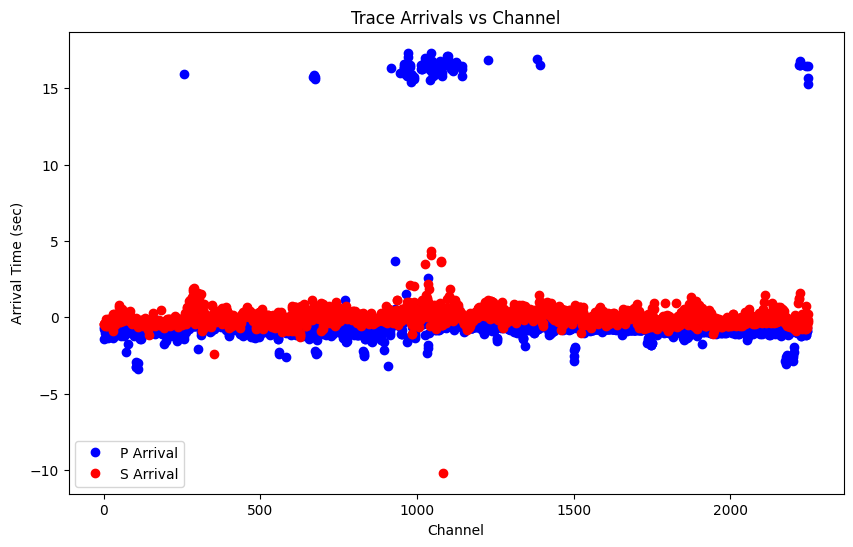

In [140]:
#plot to see detrended data and the distribution of the data compared between the p and s arrivals
plt.figure(figsize=(10, 6))
  

plt.plot(distance_vector1, p_interp1, 'o', color='blue', label='P Arrival')
plt.plot(distance_vector1, s_interp1, 'o', color='red', label='S Arrival')

plt.title(f'Trace Arrivals vs Channel')
plt.xlabel('Channel')
plt.ylabel('Arrival Time (sec)')
plt.legend()
# Set the number of ticks to 5
plt.gca().xaxis.set_major_locator(MaxNLocator(5))

Text(0, 0.5, 'Frequency')

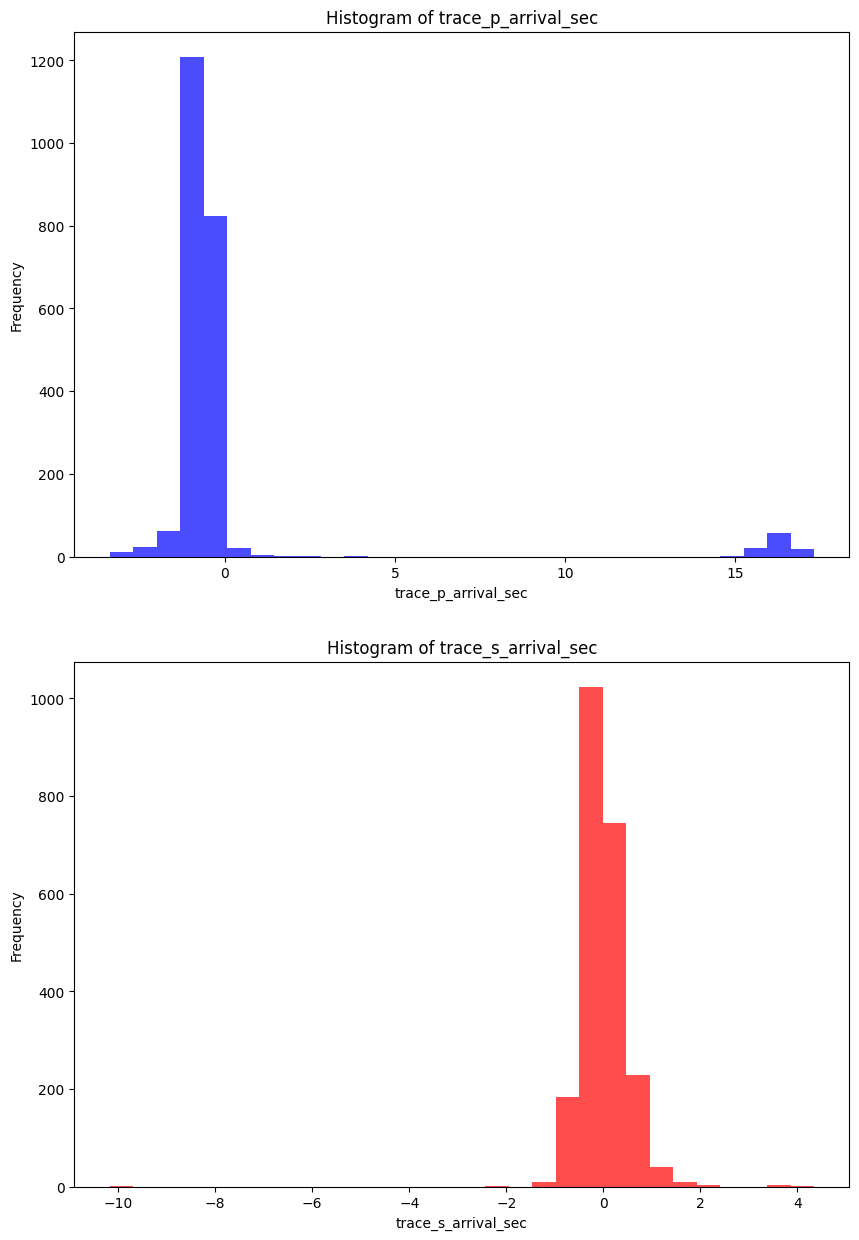

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

# Histogram for trace_p_arrival_sec
axes[i].hist(p_interp1, bins=30, color='blue', alpha=0.7)
axes[i].set_title('Histogram of trace_p_arrival_sec')
axes[i].set_xlabel('trace_p_arrival_sec')
axes[i].set_ylabel('Frequency')

# Histogram for trace_s_arrival_sec
axes[1].hist(s_interp1, bins=30, color='red', alpha=0.7)
axes[1].set_title('Histogram of trace_s_arrival_sec')
axes[1].set_xlabel('trace_s_arrival_sec')
axes[1].set_ylabel('Frequency')

In [142]:
p_mean = p_interp1.mean()
p_std = p_interp1.std()
p_2std = 2 * p_std

s_mean = s_interp1.mean()
s_std = s_interp1.std()
s_2std = 2 * s_std

print(f"P Wave Mean: {p_mean}, Std: {p_std}, 2*Std: {p_2std}")
print(f"S Wave Mean: {s_mean}, Std: {s_std}, 2*Std: {s_2std}")

P Wave Mean: -1.6168794698185392e-15, Std: 3.4436956542002584, 2*Std: 6.887391308400517
S Wave Mean: 7.834917899648038e-15, Std: 0.5083032769671256, 2*Std: 1.0166065539342513


In [ ]:
#replace the values that occur in the p_0_2250 array that are greater than 2 standard deviations from the mean in the p_interp1 array with NaN
p_0_2250[i][(p_interp1 > p_std) | (p_interp1 < -p_std)] = np.nan

#replace the values that occur in the s_interp1 array that are in the s_outliers array with NaN
s_0_2250[i][(s_interp1 > s_std) | (s_interp1 < -s_std)] = np.nan

Text(0, 0.5, 'Frequency')

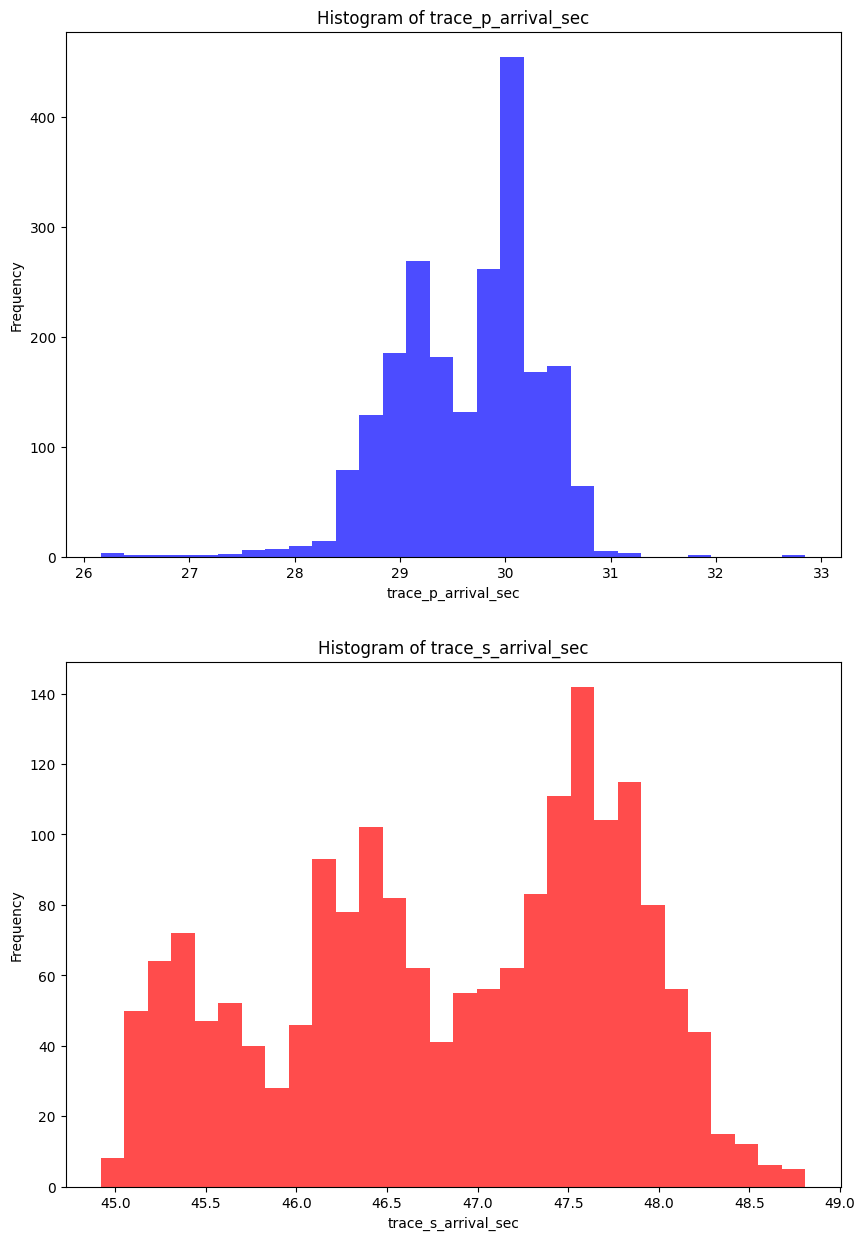

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

# Histogram for trace_p_arrival_sec
axes[i].hist(p_0_2250[i], bins=30, color='blue', alpha=0.7)
axes[i].set_title('Histogram of trace_p_arrival_sec')
axes[i].set_xlabel('trace_p_arrival_sec')
axes[i].set_ylabel('Frequency')

# Histogram for trace_s_arrival_sec
axes[1].hist(s_0_2250[i], bins=30, color='red', alpha=0.7)
axes[1].set_title('Histogram of trace_s_arrival_sec')
axes[1].set_xlabel('trace_s_arrival_sec')
axes[1].set_ylabel('Frequency')

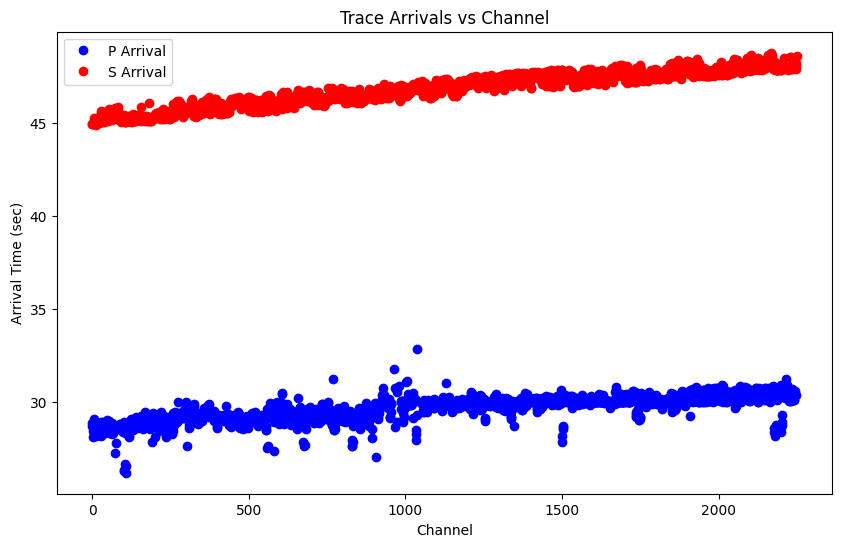

In [ ]:
#plot to see detrended data and the distribution of the data compared between the p and s arrivals
plt.figure(figsize=(10, 6))
  

plt.plot(distance_vector1, p_0_2250[i], 'o', color='blue', label='P Arrival')
plt.plot(distance_vector1, s_0_2250[i], 'o', color='red', label='S Arrival')

plt.title(f'Trace Arrivals vs Channel')
plt.xlabel('Channel')
plt.ylabel('Arrival Time (sec)')
plt.legend()
# Set the number of ticks to 5
plt.gca().xaxis.set_major_locator(MaxNLocator(5))

In [ ]:
#fill in the Nan values in the p_0_2250 and s_0_2250 arrays by interpolating the data
p_0_2250[i] = pd.Series(p_0_2250[i]).interpolate(method='linear').values
s_0_2250[i] = pd.Series(s_0_2250[i]).interpolate(method='linear').values


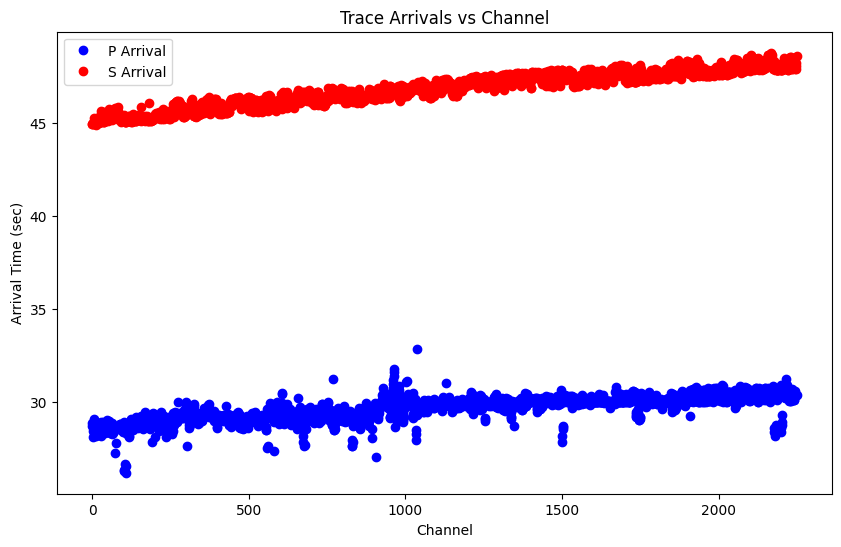

In [ ]:
#plot to see detrended data and the distribution of the data compared between the p and s arrivals
plt.figure(figsize=(10, 6))
  

plt.plot(distance_vector1, p_0_2250[i], 'o', color='blue', label='P Arrival')
plt.plot(distance_vector1, s_0_2250[i], 'o', color='red', label='S Arrival')

plt.title(f'Trace Arrivals vs Channel')
plt.xlabel('Channel')
plt.ylabel('Arrival Time (sec)')
plt.legend()
# Set the number of ticks to 5
plt.gca().xaxis.set_major_locator(MaxNLocator(5))

In [ ]:
#do it again

p_coeffs_individual = np.polyfit(distance_vector1, p_0_2250[i], deg=1)
s_coeffs_individual = np.polyfit(distance_vector1, s_0_2250[i], deg=1)

# # Calculate the trends
p_trend_individual = np.polyval(p_coeffs_individual, distance_vector1)
s_trend_individual = np.polyval(s_coeffs_individual, distance_vector1)

# # Detrend by subtracting the individual trends
p_interp1 =  p_0_2250[i] - p_trend_individual
s_interp1 =  s_0_2250[i] - s_trend_individual

p_mean = p_interp1.mean()
p_std = p_interp1.std()
p_2std = 2 * p_std

s_mean = s_interp1.mean()
s_std = s_interp1.std()
s_2std = 2 * s_std

#replace the values that occur in the p_0_2250 array that are greater than 2 standard deviations from the mean in the p_interp1 array with NaN
p_0_2250[i][(p_interp1 > p_std) | (p_interp1 < -p_std)] = np.nan

#replace the values that occur in the s_interp1 array that are in the s_outliers array with NaN
s_0_2250[i][(s_interp1 > s_std) | (s_interp1 < -s_std)] = np.nan

#fill in the Nan values in the p_0_2250 and s_0_2250 arrays by interpolating the data
p_0_2250[i] = pd.Series(p_0_2250[i]).interpolate(method='linear').values
s_0_2250[i] = pd.Series(s_0_2250[i]).interpolate(method='linear').values

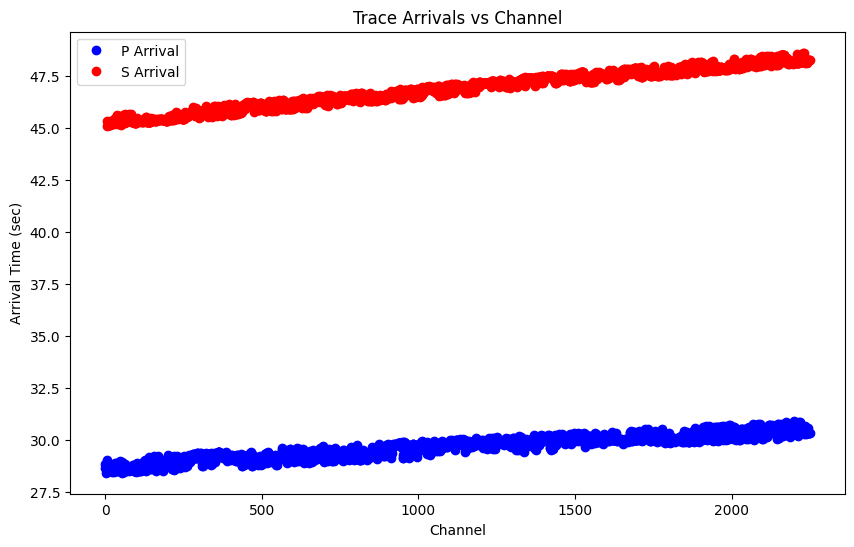

In [ ]:
#plot to see detrended data and the distribution of the data compared between the p and s arrivals
plt.figure(figsize=(10, 6))
  

plt.plot(distance_vector1, p_0_2250[i], 'o', color='blue', label='P Arrival')
plt.plot(distance_vector1, s_0_2250[i], 'o', color='red', label='S Arrival')

plt.title(f'Trace Arrivals vs Channel')
plt.xlabel('Channel')
plt.ylabel('Arrival Time (sec)')
plt.legend()
# Set the number of ticks to 5
plt.gca().xaxis.set_major_locator(MaxNLocator(5))

In [ ]:
p_0_2250.shape
#any nans
print("Number of NaNs in p_0_2250:", np.isnan(p_0_2250[i]).sum())
print("Number of NaNs in s_0_2250:", np.isnan(s_0_2250[i]).sum())

Number of NaNs in p_0_2250: 0
Number of NaNs in s_0_2250: 6


In [ ]:
p_0_2250[i] = pd.Series(p_0_2250[i]).interpolate(method='linear', limit_direction='both').values
s_0_2250[i] = pd.Series(s_0_2250[i]).interpolate(method='linear', limit_direction='both').values

print("Number of NaNs in p_0_2250:", np.isnan(p_0_2250[i]).sum())
print("Number of NaNs in s_0_2250:", np.isnan(s_0_2250[i]).sum())

Number of NaNs in p_0_2250: 0
Number of NaNs in s_0_2250: 0


(95, 2250)

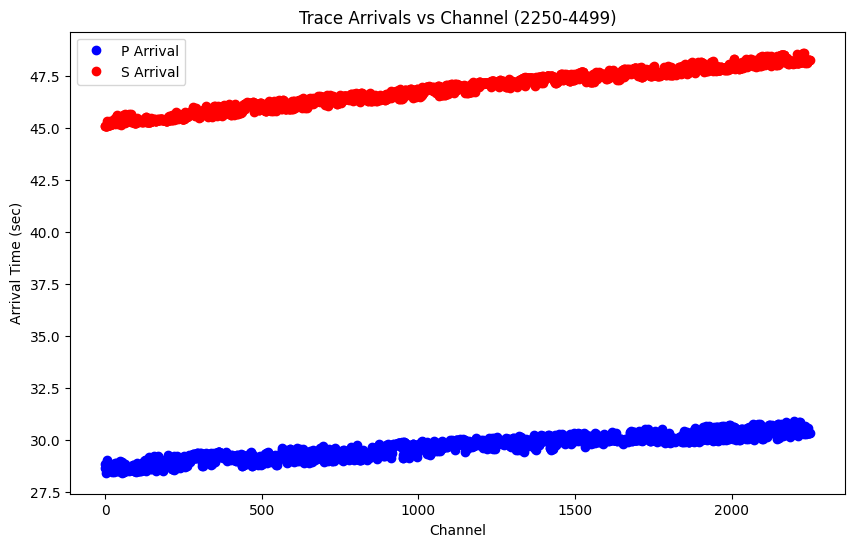

In [ ]:
# Plot the detrended data
plt.figure(figsize=(10, 6))
plt.plot(distance_vector1, p_0_2250[i], 'o', color='blue', label='P Arrival')
plt.plot(distance_vector1, s_0_2250[i], 'o', color='red', label='S Arrival')
plt.title('Trace Arrivals vs Channel (2250-4499)')
plt.xlabel('Channel')
plt.ylabel('Arrival Time (sec)')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(5))

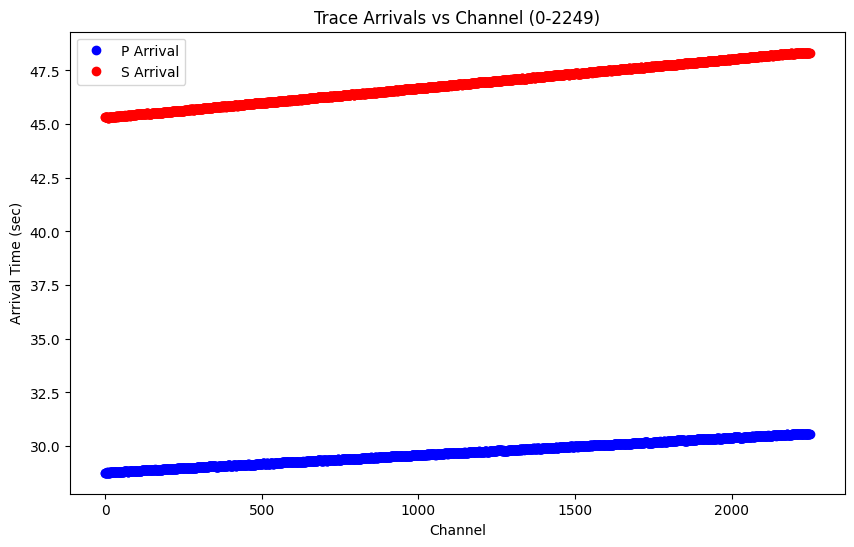

In [ ]:
# Use distance_vector1, p_0_2250, s_0_2250 for the first half (0-2249)
# Create arrays to store detrended/interpolated picks for the first half
p_interp1 = np.zeros((1, 2250))
s_interp1 = np.zeros((1, 2250))

# Fit individual polynomials for the first row
p_coeffs1 = np.polyfit(distance_vector1, p_0_2250[i], deg=1)
s_coeffs1 = np.polyfit(distance_vector1, s_0_2250[i], deg=1)

# Calculate the trends
p_trend1 = np.polyval(p_coeffs1, distance_vector1)
s_trend1 = np.polyval(s_coeffs1, distance_vector1)

# Detrend by subtracting the individual trends
p_interp1 = p_0_2250[i] - p_trend1
s_interp1 = s_0_2250[i] - s_trend1

# Calculate mean and std
p1_mean = p_interp1.mean()
p1_std = p_interp1.std()
s1_mean = s_interp1.mean()
s1_std = s_interp1.std()

# Replace outliers with NaN
p_0_2250[i][(p_interp1 > p1_std) | (p_interp1 < -p1_std)] = np.nan
s_0_2250[i][(s_interp1 > s1_std) | (s_interp1 < -s1_std)] = np.nan

# Interpolate to fill NaNs
p_0_2250[i] = pd.Series(p_0_2250[i]).interpolate(method='linear', limit_direction='both').values
s_0_2250[i] = pd.Series(s_0_2250[i]).interpolate(method='linear', limit_direction='both').values

# Detrend again after interpolation
p_coeffs1 = np.polyfit(distance_vector1, p_0_2250[i], deg=1)
s_coeffs1 = np.polyfit(distance_vector1, s_0_2250[i], deg=1)
p_trend1 = np.polyval(p_coeffs1, distance_vector1)
s_trend1 = np.polyval(s_coeffs1, distance_vector1)
p_interp1 = p_0_2250[i] - p_trend1
s_interp1 = s_0_2250[i] - s_trend1

# Calculate mean and std
p1_mean = p_interp1.mean()
p1_std = p_interp1.std()
s1_mean = s_interp1.mean()
s1_std = s_interp1.std()

# Replace outliers with NaN
p_0_2250[i][(p_interp1 > p1_std) | (p_interp1 < -p1_std)] = np.nan
s_0_2250[i][(s_interp1 > s1_std) | (s_interp1 < -s1_std)] = np.nan

# Interpolate to fill NaNs
p_0_2250[i] = pd.Series(p_0_2250[i]).interpolate(method='linear', limit_direction='both').values
s_0_2250[i] = pd.Series(s_0_2250[i]).interpolate(method='linear', limit_direction='both').values

# Plot the detrended data
plt.figure(figsize=(10, 6))
plt.plot(distance_vector1, p_0_2250[i], 'o', color='blue', label='P Arrival')
plt.plot(distance_vector1, s_0_2250[i], 'o', color='red', label='S Arrival')
plt.title('Trace Arrivals vs Channel (0-2249)')
plt.xlabel('Channel')
plt.ylabel('Arrival Time (sec)')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(5))


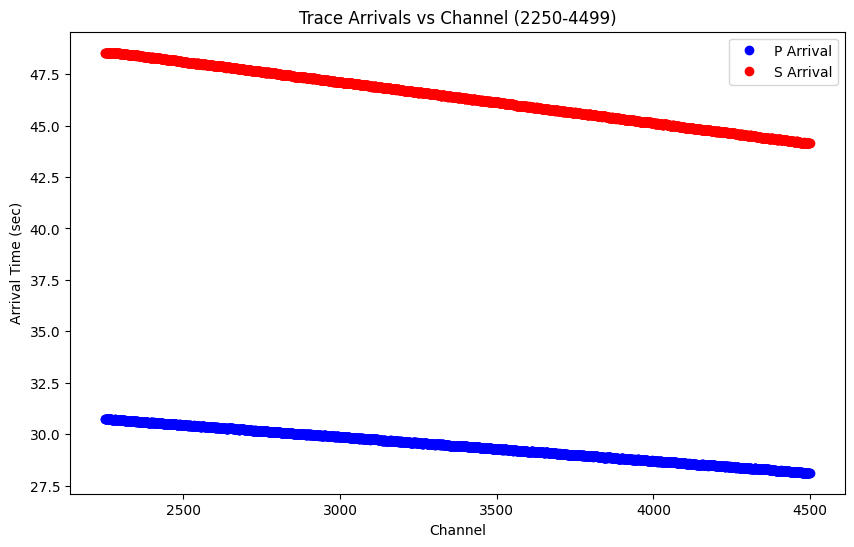

In [ ]:
# Create a numpy array for the distance vector for the second half (2250 to 4499)
distance_vector2 = np.arange(2250, 4500, 1)

# Create arrays to store detrended/interpolated picks for the second half
p_interp2 = np.zeros((p_2250_4500.shape[i], 2250))
s_interp2 = np.zeros((s_2250_4500.shape[i], 2250))

# Fit individual polynomials for the first row
p_coeffs2 = np.polyfit(distance_vector2, p_2250_4500[i], deg=1)
s_coeffs2 = np.polyfit(distance_vector2, s_2250_4500[i], deg=1)

# Calculate the trends
p_trend2 = np.polyval(p_coeffs2, distance_vector2)
s_trend2 = np.polyval(s_coeffs2, distance_vector2)

# Detrend by subtracting the individual trends
p_interp2 = p_2250_4500[i] - p_trend2
s_interp2 = s_2250_4500[i] - s_trend2

# Calculate mean and std
p2_mean = p_interp2.mean()
p2_std = p_interp2.std()
s2_mean = s_interp2.mean()
s2_std = s_interp2.std()

# Replace outliers with NaN
p_2250_4500[i][(p_interp2 > p2_std) | (p_interp2 < -p2_std)] = np.nan
s_2250_4500[i][(s_interp2 > s2_std) | (s_interp2 < -s2_std)] = np.nan

# Interpolate to fill NaNs
p_2250_4500[i] = pd.Series(p_2250_4500[i]).interpolate(method='linear', limit_direction='both').values
s_2250_4500[i] = pd.Series(s_2250_4500[i]).interpolate(method='linear', limit_direction='both').values

# Detrend again after interpolation
p_coeffs2 = np.polyfit(distance_vector2, p_2250_4500[i], deg=1)
s_coeffs2 = np.polyfit(distance_vector2, s_2250_4500[i], deg=1)
p_trend2 = np.polyval(p_coeffs2, distance_vector2)
s_trend2 = np.polyval(s_coeffs2, distance_vector2)
p_interp2 = p_2250_4500[i] - p_trend2
s_interp2 = s_2250_4500[i] - s_trend2

# Calculate mean and std
p2_mean = p_interp2.mean()
p2_std = p_interp2.std()
s2_mean = s_interp2.mean()
s2_std = s_interp2.std()

# Replace outliers with NaN
p_2250_4500[i][(p_interp2 > p2_std) | (p_interp2 < -p2_std)] = np.nan
s_2250_4500[i][(s_interp2 > s2_std) | (s_interp2 < -s2_std)] = np.nan

# Interpolate to fill NaNs
p_2250_4500[i] = pd.Series(p_2250_4500[i]).interpolate(method='linear', limit_direction='both').values
s_2250_4500[i] = pd.Series(s_2250_4500[i]).interpolate(method='linear', limit_direction='both').values

# Plot the detrended data
plt.figure(figsize=(10, 6))
plt.plot(distance_vector2, p_2250_4500[i], 'o', color='blue', label='P Arrival')
plt.plot(distance_vector2, s_2250_4500[i], 'o', color='red', label='S Arrival')
plt.title('Trace Arrivals vs Channel (2250-4499)')
plt.xlabel('Channel')
plt.ylabel('Arrival Time (sec)')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(5))

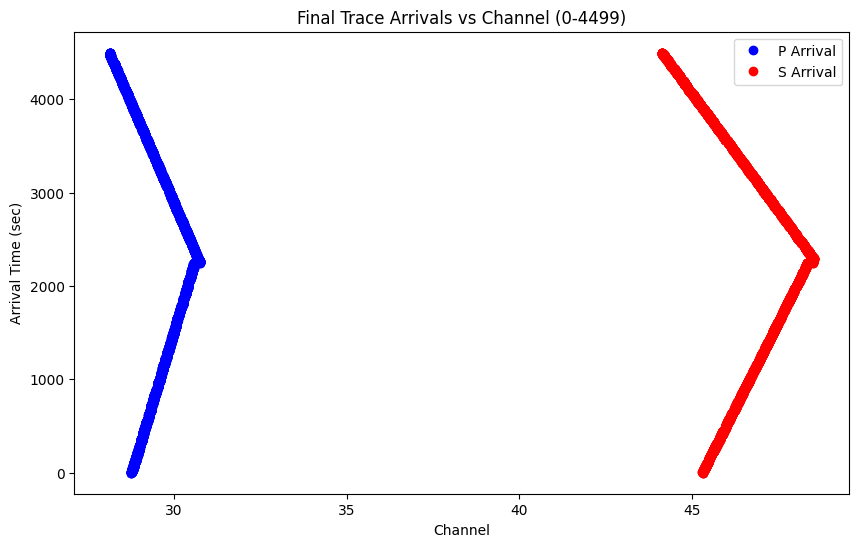

In [ ]:
#join the two halves of the picks together
p_final = np.concatenate((p_0_2250[i], p_2250_4500[i]))
s_final = np.concatenate((s_0_2250[i], s_2250_4500[i]))
# Plot the final picks
plt.figure(figsize=(10, 6))
plt.plot(p_final, np.arange(0, 4500, 1),  'o', color='blue', label='P Arrival')
plt.plot(s_final, np.arange(0, 4500, 1),  'o', color='red', label='S Arrival')
plt.title('Final Trace Arrivals vs Channel (0-4499)')
plt.xlabel('Channel')
plt.ylabel('Arrival Time (sec)')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(5))

In [ ]:
cleaned_p_waves = np.zeros((95, 4500))
cleaned_s_waves = np.zeros((95, 4500))

for i in range(0, 95):
    
    p_interp1 = np.zeros((1, 2250))
    s_interp1 = np.zeros((1, 2250))

    # Fit individual polynomials for the first row
    p_coeffs1 = np.polyfit(distance_vector1, p_0_2250[i], deg=1)
    s_coeffs1 = np.polyfit(distance_vector1, s_0_2250[i], deg=1)

    # Calculate the trends
    p_trend1 = np.polyval(p_coeffs1, distance_vector1)
    s_trend1 = np.polyval(s_coeffs1, distance_vector1)

    # Detrend by subtracting the individual trends
    p_interp1 = p_0_2250[i] - p_trend1
    s_interp1 = s_0_2250[i] - s_trend1

    # Calculate mean and std
    p1_mean = p_interp1.mean()
    p1_std = p_interp1.std()
    s1_mean = s_interp1.mean()
    s1_std = s_interp1.std()

    # Replace outliers with NaN
    p_0_2250[i][(p_interp1 > p1_std) | (p_interp1 < -p1_std)] = np.nan
    s_0_2250[i][(s_interp1 > s1_std) | (s_interp1 < -s1_std)] = np.nan

    # Interpolate to fill NaNs
    p_0_2250[i] = pd.Series(p_0_2250[i]).interpolate(method='linear', limit_direction='both').values
    s_0_2250[i] = pd.Series(s_0_2250[i]).interpolate(method='linear', limit_direction='both').values

    # Detrend again after interpolation
    p_coeffs1 = np.polyfit(distance_vector1, p_0_2250[i], deg=1)
    s_coeffs1 = np.polyfit(distance_vector1, s_0_2250[i], deg=1)
    p_trend1 = np.polyval(p_coeffs1, distance_vector1)
    s_trend1 = np.polyval(s_coeffs1, distance_vector1)
    p_interp1 = p_0_2250[i] - p_trend1
    s_interp1 = s_0_2250[i] - s_trend1

    # Calculate mean and std
    p1_mean = p_interp1.mean()
    p1_std = p_interp1.std()
    s1_mean = s_interp1.mean()
    s1_std = s_interp1.std()

    # Replace outliers with NaN
    p_0_2250[i][(p_interp1 > p1_std) | (p_interp1 < -p1_std)] = np.nan
    s_0_2250[i][(s_interp1 > s1_std) | (s_interp1 < -s1_std)] = np.nan

    # Interpolate to fill NaNs
    p_0_2250[i] = pd.Series(p_0_2250[i]).interpolate(method='linear', limit_direction='both').values
    s_0_2250[i] = pd.Series(s_0_2250[i]).interpolate(method='linear', limit_direction='both').values

    # Create a numpy array for the distance vector for the second half (2250 to 4499)
    distance_vector2 = np.arange(2250, 4500, 1)

    # Create arrays to store detrended/interpolated picks for the second half
    p_interp2 = np.zeros((1, 2250))
    s_interp2 = np.zeros((1, 2250))

    # Fit individual polynomials for the first row
    p_coeffs2 = np.polyfit(distance_vector2, p_2250_4500[i], deg=1)
    s_coeffs2 = np.polyfit(distance_vector2, s_2250_4500[i], deg=1)

    # Calculate the trends
    p_trend2 = np.polyval(p_coeffs2, distance_vector2)
    s_trend2 = np.polyval(s_coeffs2, distance_vector2)

    # Detrend by subtracting the individual trends
    p_interp2 = p_2250_4500[i] - p_trend2
    s_interp2 = s_2250_4500[i] - s_trend2

    # Calculate mean and std
    p2_mean = p_interp2.mean()
    p2_std = p_interp2.std()
    s2_mean = s_interp2.mean()
    s2_std = s_interp2.std()

    # Replace outliers with NaN
    p_2250_4500[i][(p_interp2 > p2_std) | (p_interp2 < -p2_std)] = np.nan
    s_2250_4500[i][(s_interp2 > s2_std) | (s_interp2 < -s2_std)] = np.nan

    # Interpolate to fill NaNs
    p_2250_4500[i] = pd.Series(p_2250_4500[i]).interpolate(method='linear', limit_direction='both').values
    s_2250_4500[i] = pd.Series(s_2250_4500[i]).interpolate(method='linear', limit_direction='both').values

    # Detrend again after interpolation
    p_coeffs2 = np.polyfit(distance_vector2, p_2250_4500[i], deg=1)
    s_coeffs2 = np.polyfit(distance_vector2, s_2250_4500[i], deg=1)
    p_trend2 = np.polyval(p_coeffs2, distance_vector2)
    s_trend2 = np.polyval(s_coeffs2, distance_vector2)
    p_interp2 = p_2250_4500[i] - p_trend2
    s_interp2 = s_2250_4500[i] - s_trend2

    # Calculate mean and std
    p2_mean = p_interp2.mean()
    p2_std = p_interp2.std()
    s2_mean = s_interp2.mean()
    s2_std = s_interp2.std()

    # Replace outliers with NaN
    p_2250_4500[i][(p_interp2 > p2_std) | (p_interp2 < -p2_std)] = np.nan
    s_2250_4500[i][(s_interp2 > s2_std) | (s_interp2 < -s2_std)] = np.nan

    # Interpolate to fill NaNs
    p_2250_4500[i] = pd.Series(p_2250_4500[i]).interpolate(method='linear', limit_direction='both').values
    s_2250_4500[i] = pd.Series(s_2250_4500[i]).interpolate(method='linear', limit_direction='both').values

    cleaned_p_waves[i] = np.concatenate((p_0_2250[i], p_2250_4500[i]))
    cleaned_s_waves[i] = np.concatenate((s_0_2250[i], s_2250_4500[i]))


In [174]:
#plot the cleaned p and s waves and save pngs of all the date using a for loop
for i in range(0, 95):
    plt.figure(figsize=(10, 6))
    plt.plot(cleaned_p_waves[i], np.arange(0, 4500, 1), 'o', color='blue', label='P Arrival')
    plt.plot(cleaned_s_waves[i], np.arange(0, 4500, 1), 'o', color='red', label='S Arrival')
    plt.title(f'Final Trace Arrivals vs Channel (0-4499) for Trace {i}')
    plt.xlabel('Arrival Time (sec)')
    plt.xlim(0,60)
    plt.ylim(0, 4500)
    plt.ylabel('Channel #')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(5))
    plt.savefig("/home/arose17/FM_Segmentation_DAS/src/data/pick_masking/cleaned_picks_AR/cleaned_pick " + str(i) + ".png")
    plt.close()


In [175]:
#save cleaned_p_waves and cleaned_s_waves to numpy files
np.save('/home/arose17/FM_Segmentation_DAS/src/data/pick_masking/cleaned_p_waves.npy', cleaned_p_waves)
np.save('/home/arose17/FM_Segmentation_DAS/src/data/pick_masking/cleaned_s_waves.npy', cleaned_s_waves)
